# Scalar Basics in PixelPrism

This tutorial introduces the zero-dimensional **Tensor** (also known as a *scalar*)
and walks through every creation path, manipulation primitive, and arithmetic
operator available in `pixelprism.math`. Scalars form the foundation of the
symbolic math engine, so understanding them now will make vector, matrix, and
autodiff workflows far easier later on.

## Imports and helper configuration

We'll import NumPy alongside PixelPrism's tensor core, the scalar helper
factories, and both arithmetic APIs (direct `MathExpr` helpers and the functional
module).

In [1]:
import numpy as np
from pixelprism.math import utils, DType, Tensor, MathNode
from pixelprism.math.functional import elementwise as F
import pixelprism.inspect as pinspect
from pixelprism.math.render import render_latex
from pixelprism.math.functional import trigo as T


## Creating scalars with the `Tensor` constructor

The lowest-level API instantiates a `Tensor` directly. Passing Python numbers or
NumPy scalars automatically normalizes them to zero-dimensional arrays while
preserving dtype information.

In [2]:
alpha = Tensor(name="alpha", data=3.5)
beta = Tensor(name="beta", data=2, dtype=DType.FLOAT32)

print(alpha)
print(beta)
print(f"alpha.dimensions: {alpha.shape.dims}, dtype: {alpha.dtype}")
print(f"beta.dimensions: {beta.shape.dims}, dtype: {beta.dtype}")

tensor(alpha, 3.5, dtype=DType.FLOAT32, shape=())
tensor(beta, 2.0, dtype=DType.FLOAT32, shape=())
alpha.dimensions: (), dtype: DType.FLOAT32
beta.dimensions: (), dtype: DType.FLOAT32


## Scalar constructor shortcuts from `pixelprism.math.utils`

Utility helpers wrap common allocation patterns. `utils.scalar` ensures the new
tensor is zero-dimensional, while `utils.tensor` lets us wrap an existing NumPy
scalar buffer without copying.

In [3]:
gamma = utils.scalar(name="gamma", value=1.25, dtype=np.float64)
delta = utils.tensor(name="delta", data=[[3, 4], [5, 5]], mutable=False)
print(gamma)
print(delta)

tensor(gamma, 1.25, dtype=DType.FLOAT64, shape=())
ctensor(delta, [[3.0, 4.0], [5.0, 5.0]], dtype=DType.FLOAT64, shape=(2, 2))


## Inspecting metadata and mutability

Scalars expose the same metadata helpers as higher-rank tensors. Because scalars
are leaves in the computation graph, we can mutate them in-place with `set(...)`
to emulate variable updates.

In [4]:
print(f"gamma rank: {gamma.rank}, ndim: {gamma.ndim}, size: {gamma.size}")
print(f"gamma mutable: {gamma.mutable}")

print("Original gamma value:", gamma.value)
gamma.set(np.array(5.0, dtype=np.float32))
print("Updated gamma value:", gamma.value)

gamma rank: 0, ndim: 0, size: 1
gamma mutable: True
Original gamma value: 1.25
Updated gamma value: 5.0


## Arithmetic via `MathExpr` helper methods

`MathExpr.add/sub/mul/div` create symbolic nodes that connect scalars. These
nodes remember their inputs, shape, and dtype, and lazily evaluate when asked.

In [5]:
direct_ops = {
    "alpha + beta": MathNode.add(alpha, beta),
    "alpha - beta": MathNode.sub(alpha, beta),
    "alpha * beta": MathNode.mul(alpha, beta),
    "alpha / beta": MathNode.div(alpha, beta),
    "-alpha": MathNode.neg(alpha),
}

for label, node in direct_ops.items():
    print(f"{label} -> repr: {node}")
    print(f"    evaluated value: {float(node.eval())}")


alpha + beta -> repr: <MathExpr #4 add float32 () c:2>
    evaluated value: 5.5
alpha - beta -> repr: <MathExpr #5 sub float32 () c:2>
    evaluated value: 1.5
alpha * beta -> repr: <MathExpr #6 mul float32 () c:2>
    evaluated value: 7.0
alpha / beta -> repr: <MathExpr #7 div float32 () c:2>
    evaluated value: 1.75
-alpha -> repr: <MathExpr #8 neg float32 () c:1>
    evaluated value: -3.5


## Arithmetic via the functional module

If you prefer functional-style helpers, `pixelprism.math.functional.arithmetic`
exposes the same operators. They build the identical expression nodes shown
above, so you can mix and match styles.

In [6]:
functional_ops = {
    "add": F.add(alpha, beta),
    "sub": F.sub(alpha, beta),
    "mul": F.mul(alpha, beta),
    "div": F.div(alpha, beta),
    "neg": F.neg(alpha),
}

for label, node in functional_ops.items():
    print(f"Functional {label}: {node.name} -> {float(node.eval())}")


Functional add: alpha + beta -> 5.5
Functional sub: alpha - beta -> 1.5
Functional mul: alpha * beta -> 7.0
Functional div: alpha / beta -> 1.75
Functional neg: -alpha -> -3.5


## Building and visualizing a scalar expression graph

Let's compose a slightly richer scalar expression that will show how nodes
compose:

$$h(Alpha, Beta, \gamma) = \frac{Alpha \times Beta}{Beta + \gamma}$$

The following helper prints a lightweight tree so we can see which scalars feed
the numerator and denominator.

In [7]:
numerator = MathNode.mul(alpha, beta)
denominator = MathNode.add(beta, gamma)
scalar_expr = MathNode.div(numerator, denominator)

tree_viz = pinspect.inspect(scalar_expr, backend="graphviz")
tree_viz

latex_image = render_latex(scalar_expr, output_path="scalar_expr.svg")
latex_image

print("Expression evaluation:", float(scalar_expr.eval()))


This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
(./tmp_latex/equation.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-01-22>
(/usr/share/texlive/texmf-dist/tex/latex/standalone/standalone.cls
Document Class: standalone 2022/10/10 v1.3b Class to compile TeX sub-files stan
dalone
(/usr/share/texlive/texmf-dist/tex/latex/tools/shellesc.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifluatex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty))
(/usr/share/texlive/texmf-dist/tex/latex/xkeyval/xkeyval.sty
(/usr/share/texlive/texmf-dist/tex/generic/xkeyval/xkeyval.tex
(/usr/share/texlive/texmf-dist/tex/generic/xkeyval/xkvutils.tex
(/usr/share/texlive/texmf-dist/tex/generic/xkeyval/keyval.tex))))
(/usr/share/texlive/texmf-dist/tex/latex/standalone/standalone.cfg)
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2023/05/17 

pre-processing DVI file (format version 2)
processing page 1
  computing extents based on data set by preview package (version 13.2)
  width=24.139034pt, height=22.513477pt, depth=0pt
  graphic size: 24.139034pt x 22.513466pt (8.4839mm x 7.912578mm)
  output written to scalar_expr.svg
1 of 1 page converted in 0.133815 seconds


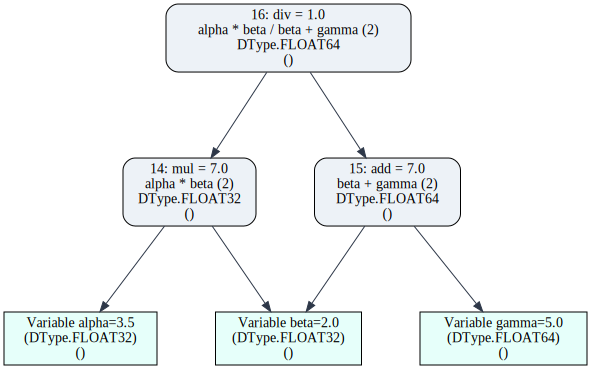

In [8]:
tree_viz

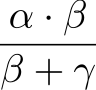

In [9]:
latex_image

In [10]:
from pixelprism.math.render import to_latex
scalar_expr_latex = to_latex(scalar_expr)
scalar_expr_latex

'\\frac{\\alpha \\cdot \\beta}{\\beta + \\gamma}'

## Advanced operators: power, exponential, and trigonometry

Scalar expressions can mix higher-order operators such as ``pow``/``exp`` with
trigonometric functions. The next cell composes them using the same
``MathExpr`` graph helpers as before.

In [15]:
two = utils.scalar(name="two", value=2.0, dtype=DType.FLOAT64, mutable=False)
offset = utils.scalar(name="offset", value=1.0, dtype=DType.FLOAT64, mutable=False)

pow_beta_two = F.pow(beta, two)
exp_alpha = F.exp(alpha)
sin_gamma = T.sin(gamma)
cos_alpha = T.cos(alpha)

advanced_scalar_expr = MathNode.add(
    MathNode.mul(exp_alpha, sin_gamma),
    MathNode.div(pow_beta_two, MathNode.add(cos_alpha, offset))
)

print("Advanced ops evaluation:", float(advanced_scalar_expr.eval()))

Advanced ops evaluation: -21096.857935773307


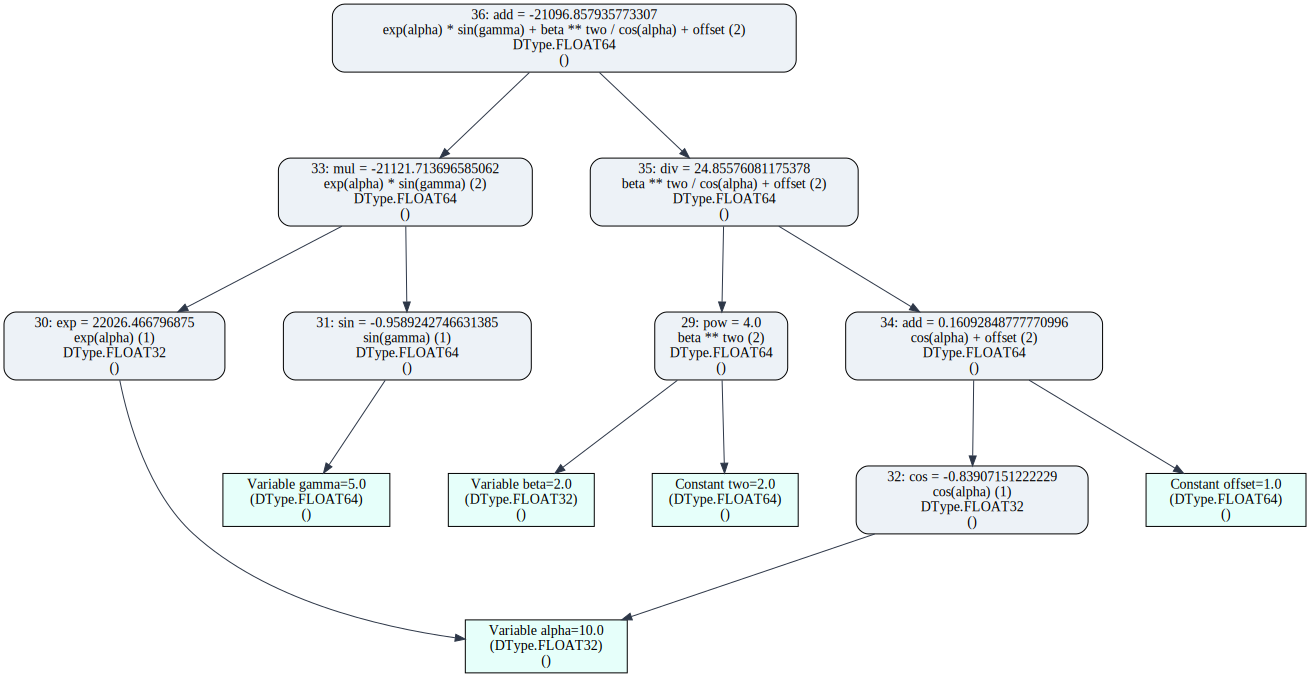

In [16]:
advanced_scalar_tree = pinspect.inspect(advanced_scalar_expr, backend="graphviz")
advanced_scalar_tree

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
(./tmp_latex/equation.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-01-22>
(/usr/share/texlive/texmf-dist/tex/latex/standalone/standalone.cls
Document Class: standalone 2022/10/10 v1.3b Class to compile TeX sub-files stan
dalone
(/usr/share/texlive/texmf-dist/tex/latex/tools/shellesc.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifluatex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty))
(/usr/share/texlive/texmf-dist/tex/latex/xkeyval/xkeyval.sty
(/usr/share/texlive/texmf-dist/tex/generic/xkeyval/xkeyval.tex
(/usr/share/texlive/texmf-dist/tex/generic/xkeyval/xkvutils.tex
(/usr/share/texlive/texmf-dist/tex/generic/xkeyval/keyval.tex))))
(/usr/share/texlive/texmf-dist/tex/latex/standalone/standalone.cfg)
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2023/05/17 

pre-processing DVI file (format version 2)
processing page 1
  computing extents based on data set by preview package (version 13.2)
  width=125.745144pt, height=24.264621pt, depth=0pt
  graphic size: 125.745144pt x 24.264606pt (44.194364mm x 8.528033mm)
  output written to scalar_trig_expr.svg
1 of 1 page converted in 0.0968862 seconds


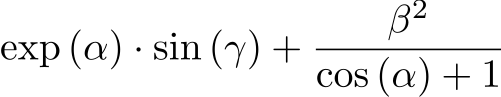

In [18]:
advanced_scalar_latex = render_latex(advanced_scalar_expr, output_path="scalar_trig_expr.svg")
advanced_scalar_latex

## Evaluating expressions under different values

`Tensor.set(...)` permanently mutates a scalar leaf. Alternatively, pass overrides
into `MathExpr.eval(...)` to temporarily bind new runtime values (useful for
feeding placeholders).

In [19]:
print("Baseline evaluation:", float(scalar_expr.eval()))

alpha.set(np.array(10.0, dtype=np.float32))
print("After mutating alpha with set(...):", float(scalar_expr.eval()))

custom_result = scalar_expr.eval(alpha=np.array(2.0, dtype=np.float32), beta=np.array(4.0, dtype=np.float32))
print("Temporary override via eval(...):", float(custom_result))

print("alpha remains mutated (set) value:", float(alpha.value))

Baseline evaluation: 2.857142857142857
After mutating alpha with set(...): 2.857142857142857
Temporary override via eval(...): 0.8888888888888888
alpha remains mutated (set) value: 10.0
